In [1]:
using SparseArrays
using LinearAlgebra
using LinearAlgebra.LAPACK
using Arpack
using Plots

In [44]:
function Lp(L)
    return sparse(1:2*L, 2:2*L+1, ones(Float64, Int(2*L)), Int(2*L+1), Int(2*L+1)) 
end

function Lm(L)
    return sparse(2:2*L+1, 1:2*L, ones(Float64, Int(2*L)), Int(2*L+1), Int(2*L+1))
end

function LzLz(L)
    return sparse(1:2*L+1, 1:2*L+1, map(x -> convert(Float64, x^2), -L:L))
end

function Lz(L)
    return sparse(1:2*L+1, 1:2*L+1, -L:L)
end

Lz (generic function with 1 method)

In [45]:
print(Lp(1/2))
print(Lm(2))
print(LzLz(1/2))


  ⋅   1.0
  ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅ 
 1.0   ⋅    ⋅    ⋅    ⋅ 
  ⋅   1.0   ⋅    ⋅    ⋅ 
  ⋅    ⋅   1.0   ⋅    ⋅ 
  ⋅    ⋅    ⋅   1.0   ⋅ 
 0.25   ⋅ 
  ⋅    0.25

In [4]:
function insert(matList, idxList, Nsites)
    count = 1;
    res = sparse([1], [1], [1.0]);
    dim = size(matList[1])[1];
    for i in 1:Nsites
        if i in idxList
            res = kron(res, matList[count]);
            count += 1;
        else 
            res = kron(res, sparse(I, dim, dim));
        end
    end
    return res
end

insert (generic function with 1 method)

In [148]:
function HSG(b, h, L, Nsites, BCs="OBC")
    H = ((1/2)*sum(map(idx -> insert([LzLz(L)], [idx], Nsites), 1:Nsites))
              -(h*b/2)*sum(map(idx -> insert([Lp(L)+Lm(L)], [idx], Nsites), 1:Nsites))
              - (b/2)*sum(map(idx -> insert([Lp(L), Lm(L)], [idx, idx+1], Nsites), 1:Nsites-1))
              - (b/2)*sum(map(idx -> insert([Lm(L), Lp(L)], [idx, idx+1], Nsites), 1:Nsites-1)));
    if BCs == "PBC"
        H -= (b/2)*insert([Lp(L), Lm(L)], [Nsites, 1], Nsites) + (b/2)*insert([Lm(L), Lp(L)], [Nsites, 1], Nsites)
    elseif BCs == "APBC"
        H -= (b/2)*insert([Lp(L), Lp(L)], [Nsites, 1], Nsites) + (b/2)*insert([Lm(L), Lm(L)], [Nsites, 1], Nsites)
    end
    
    return H     
end

HSG (generic function with 2 methods)

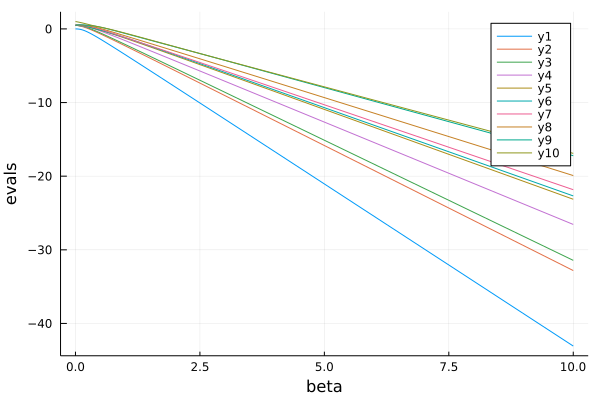

In [127]:
Nsites = 4;
targSt = 10; 
L=1; 
h = 1;
blist = 0:0.02:10.0
evalList = Array{Float64, 2}(undef, size(blist)[1], targSt);
for (i, b) in enumerate(blist)
    evals, evecs = eigs(HSG(b, h, L, Nsites), nev = targSt, which=:SR);
    evalList[i, :] = evals
end
plot(blist, evalList, xlabel = "beta", ylabel="evals")

In [7]:
plot(1:20, evals[1:20])

LoadError: UndefVarError: evals not defined

In [8]:
function cosX(x, state, L, Nsites)
    return state'*insert([Lp(L)+Lm(L)], [x], Nsites)*state/2.0;
end

function sinX(x, state, L, Nsites)
    return real(state'*insert([Lp(L)-Lm(L)], [x], Nsites)*state/(2.0im));
end

sinX (generic function with 1 method)

In [ ]:
Nsites = 10;
targSt = 100; 
L=2; 
evals, evecs = eigs(HSG(1, 1, L, Nsites, "APBC"), nev = targSt+1, which=:SR);

In [ ]:
#p = plot(1:Nsites, [cosX(x, normalize(evecs[:, 1]), L, Nsites) for x in 1:Nsites], label = "E_1")
cosList = Array{Float64, 2}(undef, targSt, Nsites)
p = plot()
for i in 1:10:targSt
    cosList[i, :] = [cosX(x, normalize(evecs[:, i]), L, Nsites) for x in 1:Nsites];
    p = plot!(1:Nsites, cosList[i, :], label="E_"*string(i), xlabel="sites", ylabel="<cos φ(x)>", legend = :bottomleft)
end
idxmax = argmax(maximum(cosList, dims=2)-minimum(cosList, dims=2))
p = plot!(1:Nsites, cosList[idxmax[1], :], label="MAX DIF: E_"*string(idxmax[1]), xlabel="sites", ylabel="<cos φ(x)>", legend = :bottom)
p

In [153]:
cosList[idxmax[1], :]

11-element Vector{Float64}:
  2.130785685e-315
  2.136034797e-315
  1.26452355e-315
  2.14156833e-315
  2.142501286e-315
  2.13690119e-315
  0.0
  0.5
 -0.0125
  0.5
  1.239477521e-314

In [103]:
cosList[idxmax[1], :]

6-element Vector{Float64}:
 NaN
   2.716154612436e-312
 NaN
   9.22176587e-315
   0.0
 NaN

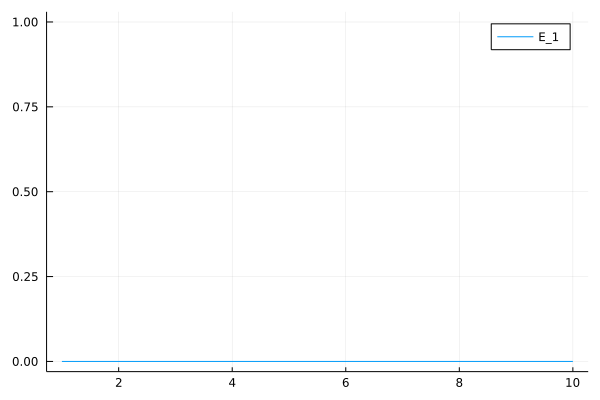

In [11]:
#p = plot(1:Nsites, [cosX(x, normalize(evecs[:, 1]), L, Nsites) for x in 1:Nsites], label = "E_1")
sinList = Array{Float64, 2}(undef, targSt, Nsites)
for i in 1:targSt
    sinList[i, :] = [sinX(x, normalize(evecs[:, i]), L, Nsites) for x in 1:Nsites];
end
idxmax = argmax(maximum(sinList, dims=2)-minimum(sinList, dims=2))
plot(1:Nsites, sinList[idxmax[1], :], label="E_"*string(idxmax[1]))

In [12]:
function Mag(state, L, Nsites)
    return state'*reduce(+, [insert([Lp(L)+Lm(L)], [x], Nsites) for x in 1:Nsites])*state/(2.0*Nsites);
end

Mag (generic function with 1 method)

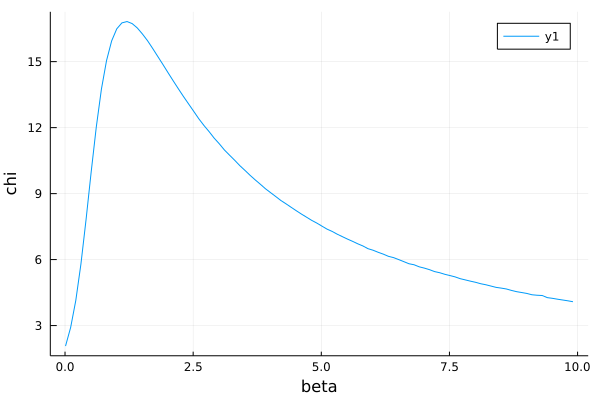

In [13]:
Nsites = 6;
targSt = 1; 
L=1; 
h = 4e-5;
delh = 1e-12;
chiList = Vector{Float64}();
blist = 0.01:0.1:10.0
for b in blist
    evals, evecs = eigs(HSG(b, h+delh, L, Nsites), nev = targSt, which=:SR);
    Mp = Mag(evecs[:, 1], L, Nsites);
    evals, evecs = eigs(HSG(b, h-delh, L, Nsites), nev = targSt, which=:SR);
    Mm = Mag(evecs[:, 1], L, Nsites);
    append!(chiList, abs(Mp-Mm)/(2*delh));
end
plot(blist, chiList, xlabel = "beta", ylabel="chi")

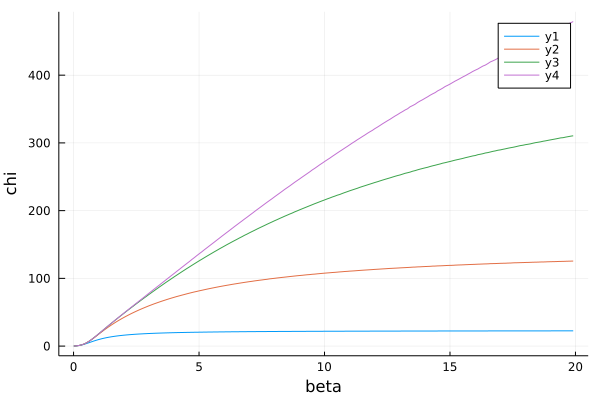

In [31]:
Nsites = 4;
targSt = 1; 
h = 4e-5;
delh = 1e-12;
p = plot()
blist = 0.01:0.1:20.0
for L in 1:4
    chiList = Vector{Float64}();
    for b in blist
        evals, evecs = eigs(HSG(b, h+delh, L, Nsites), nev = targSt, which=:SR);
        Mp = Mag(evecs[:, 1], L, Nsites);
        evals, evecs = eigs(HSG(b, h-delh, L, Nsites), nev = targSt, which=:SR);
        Mm = Mag(evecs[:, 1], L, Nsites);
        append!(chiList, abs(Mp-Mm)/(2*delh));
    end
    p = plot!(blist, chiList, xlabel = "beta", ylabel="chi")
end
p

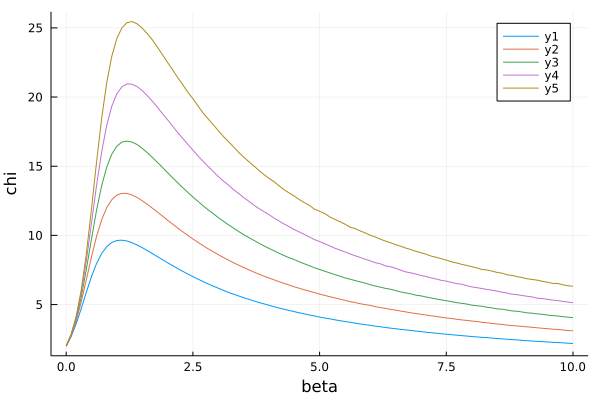

In [15]:
targSt = 1; 
L=1; 
h = 4e-5;
delh = 1e-12;
p = plot()
for Nsites in 4:8
    chiList = Vector{Float64}();
    for b in 0.0:0.1:10.0
        evals, evecs = eigs(HSG(b, h+delh, L, Nsites), nev = targSt, which=:SR);
        Mp = Mag(evecs[:, 1], L, Nsites);
        evals, evecs = eigs(HSG(b, h-delh, L, Nsites), nev = targSt, which=:SR);
        Mm = Mag(evecs[:, 1], L, Nsites);
        append!(chiList, abs(Mp-Mm)/(2*delh));
    end
    p = plot!(0.0:0.1:10.0, chiList, xlabel = "beta", ylabel="chi")
end
p

In [16]:
Nsites = 7;
targSt = 301; 
L=1; 
anim = @animate for b in 0.1:0.1:2
    evals, evecs = eigs(HSG(b, 1, L, Nsites), nev = targSt, which=:SR);
    plot(1:Nsites, [cosX(x, normalize(evecs[:, targSt]), L, Nsites) for x in 1:Nsites], label = "E_"*string(targSt), ylims = (0,1), title="b="*string(b))
end

Animation("C:\\Users\\kwibu\\AppData\\Local\\Temp\\jl_sl2YH6", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png", "000011.png", "000012.png", "000013.png", "000014.png", "000015.png", "000016.png", "000017.png", "000018.png", "000019.png", "000020.png"])

┌ Info: Saved animation to 
│   fn = C:\Users\kwibu\workspace\quantum_link\QuLAT\Hiroki\jupyter_notebooks\julia\sin.gif
└ @ Plots C:\Users\kwibu\.julia\packages\Plots\S2aH5\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\kwibu\\workspace\\quantum_link\\QuLAT\\Hiroki\\jupyter_notebooks\\julia\\sin.gif")
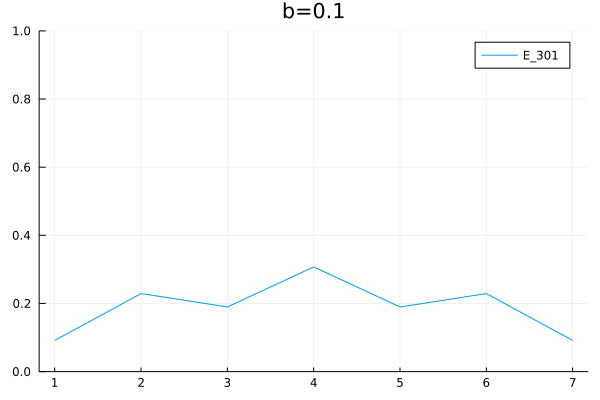

In [17]:
gif(anim, "sin.gif", fps=10)

In [18]:
function baseChange(dec, base, Ndeg)
    # LSB is in the RHS 
    if dec == 0
        count = -1
    else 
        count = floor(Int64, log(base, dec));
    end 
    
    str = "0"^(Ndeg - count - 1)
    while count >= 0
        d = dec ÷ (base^count);
        str *= string(d)
        dec -= d*(base^count); 
        count -= 1;
    end
    
    return str
end

function baseBackto10(str, base)
    # LSB is in the RHS 
    count = 0;
    res = 0;
    for s in reverse(str)
        res += parse(Int64, s)*(base^count);
        count += 1;
    end
    return res
end

baseBackto10 (generic function with 1 method)

In [19]:
function partialTr(rho, siteList, sd, Nsites)
    rhorows = rowvals(rho)
    rhovals = nonzeros(rho)
    trRho = spzeros(sd^(Nsites-size(siteList)[1]), sd^(Nsites-size(siteList)[1]))

    for col in 1:sd^Nsites
        colfluxBasis = baseChange(col-1, sd, Nsites);
        l = reduce(*, [colfluxBasis[m] for m in 1:Nsites if m ∉ siteList]);
        ll = reduce(*, [colfluxBasis[m] for m in 1:Nsites if m in siteList]);

        for i in nzrange(rho, col)
            row = rhorows[i];
            rowfluxBasis = baseChange(row-1, sd, Nsites);
            k = reduce(*, [rowfluxBasis[m] for m in 1:Nsites if m ∉ siteList]);
            kk = reduce(*, [rowfluxBasis[m] for m in 1:Nsites if m in siteList]);

            if kk == ll
                trRho[baseBackto10(k, sd)+1, baseBackto10(l, sd)+1] += rhovals[i]
            end
        end
    end
    return trRho
end


partialTr (generic function with 1 method)

In [20]:
function vNentropy(rho)
    evals, evecL, evecR = LAPACK.geev!('N', 'N', Matrix(rho))
    return -reduce(+, [ev*log(ev) for ev in evals if ev > 0])
end

vNentropy (generic function with 1 method)

In [21]:
vNentropy(partialTr(sparse([1], [1], [1.0], 9, 1)*sparse([1], [1], [1.0], 9, 1)', [1], 3, 2))

-0.0

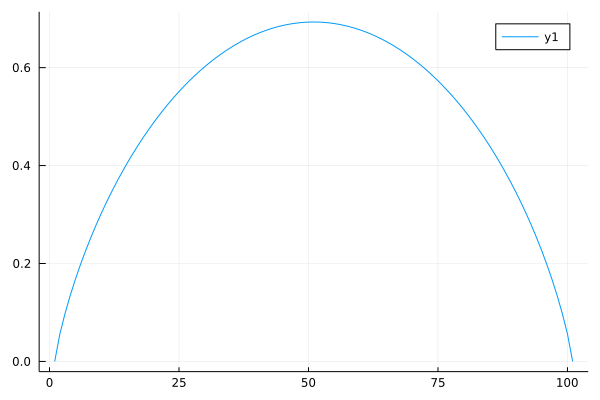

In [22]:
plot([vNentropy(partialTr(sparse([1, 9], [1, 1], [sqrt(t), sqrt(1-t)], 9, 1)*sparse([1, 9], [1, 1], [sqrt(t), sqrt(1-t)], 9, 1)', [1], 3, 2)) for t in 0.0:0.01:1.0])

In [23]:
Nsites = 4;
targSt = 1; 
L=1; 
h = 0;
eeList = Vector{Float64}();
blist = 0.01:0.01:5.0
for b in blist
    evals, evecs = eigs(HSG(b, h, L, Nsites), nev = targSt, which=:SR);
    append!(eeList,vNentropy(partialTr(sparse(evecs[:, 1]*evecs[:, 1]'), [1, 2, 3], 2*L+1, Nsites)));
end

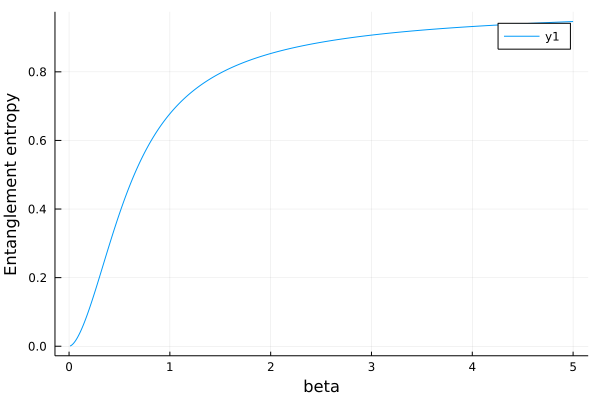

In [24]:
plot(blist, eeList, xlabel = "beta", ylabel="Entanglement entropy")

In [25]:
Nsites = 4;
targSt = 1; 
L=1; 
blist = 0.01:0.01:2.0
anim = @animate for h in 0:0.1:2
    eeList = Vector{Float64}();
    for b in blist
        evals, evecs = eigs(HSG(b, h, L, Nsites), nev = targSt, which=:SR);
        append!(eeList,vNentropy(partialTr(sparse(evecs[:, 1]*evecs[:, 1]'), [1, 2, 3], 2*L+1, Nsites)));
    end
    plot(blist, eeList, ylims = (0,1.0), title="h="*string(h));
end

Animation("C:\\Users\\kwibu\\AppData\\Local\\Temp\\jl_RQ7D2x", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000012.png", "000013.png", "000014.png", "000015.png", "000016.png", "000017.png", "000018.png", "000019.png", "000020.png", "000021.png"])

┌ Info: Saved animation to 
│   fn = C:\Users\kwibu\workspace\quantum_link\QuLAT\Hiroki\jupyter_notebooks\julia\ee.gif
└ @ Plots C:\Users\kwibu\.julia\packages\Plots\S2aH5\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\kwibu\\workspace\\quantum_link\\QuLAT\\Hiroki\\jupyter_notebooks\\julia\\ee.gif")
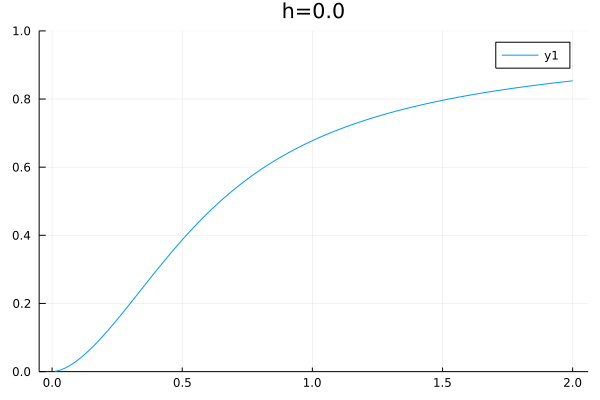

In [26]:
gif(anim, "ee.gif", fps=4)

In [27]:
function corrCos(x, y, state, L, Nsites)
    return (state'*(insert([Lp(L), Lm(L)], [x, y], Nsites) + insert([Lm(L), Lp(L)], [x, y], Nsites))*state/2.0);
end

corrCos (generic function with 1 method)

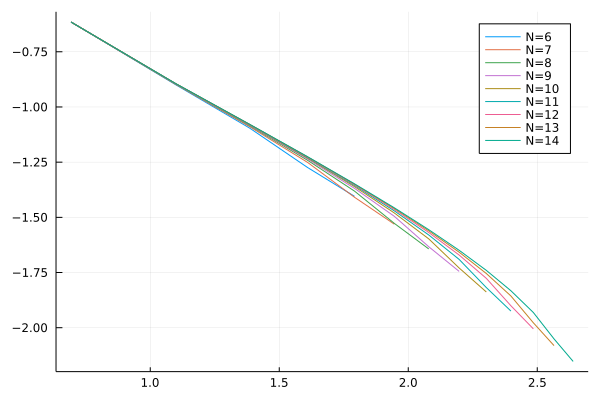

In [28]:
# two point correlation
#Nsites = 12;
L = 1;
b = 1;
h = 0;
p = plot();
for Nsites in 6:14
    evals, evecs = eigs(HSG(b, h, L, Nsites), nev = 1, which=:SR);
    p = plot!(map(log, 2:Nsites), [log(corrCos(1, y, evecs[:, 1], L, Nsites)) for y in 2:Nsites], label="N="*string(Nsites));
end
p

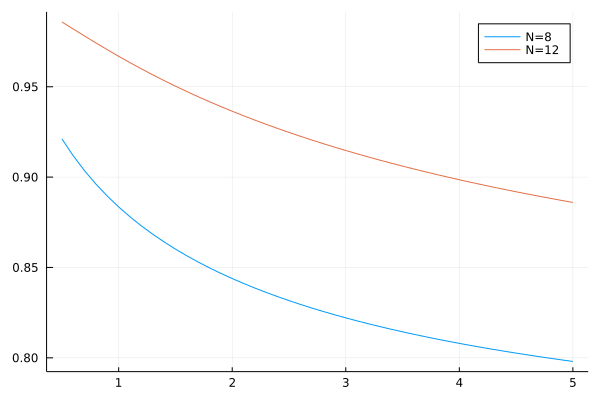

In [29]:
# ratio of two point correlations <g(L/2)>/<g(L/4)>
L = 1;
blist = 0.5:0.1:5.0;
p = plot();
h = 1;
for Nsites in [8, 12]
    rList = Vector{Float64}();
    for b in blist
        evals, evecs = eigs(HSG(b, h, L, Nsites), nev = 1, which=:SR);
        append!(rList, corrCos(1, Nsites ÷ 2, evecs[:, 1], L, Nsites)/corrCos(1, Nsites ÷ 4, evecs[:, 1], L, Nsites));
    end
    p = plot!(blist, rList, label="N="*string(Nsites))
end
p

In [57]:
function XXZ(J, d, L, Nsites)
    return J*(sum(map(idx -> insert([Lp(L), Lm(L)], [idx, idx+1], Nsites), 1:Nsites-1))
              + sum(map(idx -> insert([Lm(L), Lp(L)], [idx, idx+1], Nsites), 1:Nsites-1))
              + d* sum(map(idx -> insert([Lz(L), Lz(L)], [idx, idx+1], Nsites), 1:Nsites-1)));
end

XXZ (generic function with 1 method)

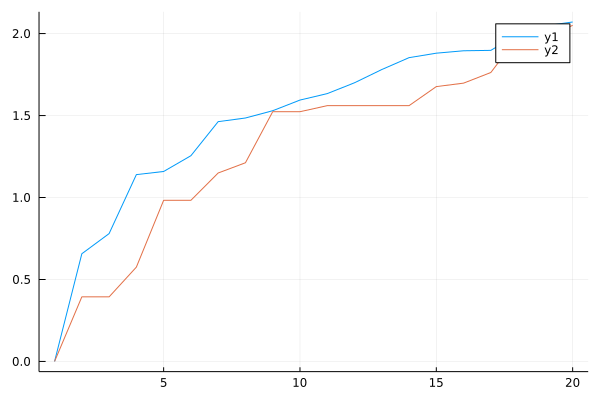

In [109]:
J = 1;
d = 1;
evals, evecs = eigs(2/(J*(1+4*d/pi))*HSG(J*(1+4*d/pi), d/(pi^2), 1/2, 12), nev = 20, which=:SR);
plot(evals .- evals[1])
evals, evecs = eigs(XXZ(J, d, 1/2, 12), nev = 20, which=:SR);
plot!(evals.- evals[1])

In [74]:
J*(1+4*d/pi)

1.1273239544735163

In [117]:
function topologicalQN(Nsites, L)
    return reduce(+, [insert([Lp(L), Lm(L)], [x, x%Nsites+1], Nsites) - insert([Lm(L), Lp(L)], [x, x%Nsites+1], Nsites) for x in 1:Nsites])/(2.0*im)
end

topologicalQN (generic function with 2 methods)

In [118]:
topologicalQN(2, 1/2)

4×4 SparseMatrixCSC{ComplexF64, Int64} with 2 stored entries:
     ⋅           ⋅          ⋅          ⋅    
     ⋅           ⋅      0.0-1.0im      ⋅    
     ⋅      -0.0+1.0im      ⋅          ⋅    
     ⋅           ⋅          ⋅          ⋅    

In [119]:
H=HSG(1, 1, 1, 2)
T=topologicalQN(2, 1)
H*T-T*H

9×9 SparseMatrixCSC{ComplexF64, Int64} with 26 stored entries:
     ⋅      0.0-0.5im      ⋅      …       ⋅           ⋅          ⋅    
 0.0-0.5im  0.0-1.0im  0.0-0.5im          ⋅           ⋅          ⋅    
     ⋅      0.0-0.5im  0.0-1.0im          ⋅           ⋅          ⋅    
 0.0+0.5im      ⋅          ⋅         -0.0+0.5im       ⋅          ⋅    
     ⋅          ⋅      0.0-1.0im      0.0+1.0im       ⋅          ⋅    
     ⋅          ⋅      0.0-0.5im  …       ⋅           ⋅      0.0-0.5im
     ⋅          ⋅          ⋅         -0.0+1.0im   0.0+0.5im      ⋅    
     ⋅          ⋅          ⋅         -0.0+0.5im  -0.0+1.0im  0.0+0.5im
     ⋅          ⋅          ⋅              ⋅      -0.0+0.5im      ⋅    